In [1]:
!mkdir -p /kaggle/input/plant-seedlings-classification/


# Imports

In [2]:
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import os
import pandas as pd
import seaborn as sns
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import inception_v3
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ReLU,Activation
from tensorflow.keras.activations import swish
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import imgaug as ia
import imgaug.augmenters as iaa
from keras.utils import layer_utils
from tensorflow.keras.utils import to_categorical
from statistics import mean
import math
import cv2
from tensorflow import keras
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Classes

In [3]:
Classes = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']

Classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

#Kaggle Import Dataset

In [4]:
import os
import glob
import zipfile
import functools

def get_kaggle_credentials():
    token_dir = os.path.join(os.path.expanduser("~"),".kaggle")
    token_file = os.path.join(token_dir, "kaggle.json")
    if not os.path.isdir(token_dir):
        os.mkdir(token_dir)
    try:
        with open(token_file,'r') as f:
            pass
    except IOError as no_file:
        try:
            from google.colab import files
        except ImportError:
            raise no_file
        uploaded = files.upload()

        if "kaggle.json" not in uploaded:
            raise ValueError("You need an API key! see: "
                           "https://github.com/Kaggle/kaggle-api#api-credentials")
        with open(token_file, "wb") as f:
            f.write(uploaded["kaggle.json"])
        os.chmod(token_file, 600)

get_kaggle_credentials()

import kaggle
def get_data(competition):
    kaggle.api.competition_download_files(competition)
   

Saving kaggle.json to kaggle.json


In [5]:
competition = 'plant-seedlings-classification'
get_data(competition)

In [6]:
train_path='/content/plant-seedlings-classification.zip'

In [7]:
from zipfile import ZipFile
with ZipFile(train_path, 'r') as zip:
  zip.extractall('/kaggle/input/plant-seedlings-classification/')

In [8]:
train_dir='/kaggle/input/plant-seedlings-classification/train/'

In [9]:
import glob

file_ = []
for i in range(12) :
    file = glob.glob(train_dir+Classes[i]+'/*.png')
    file_ += [len(file)]

(file_)

[263, 390, 287, 611, 221, 475, 654, 221, 516, 231, 496, 385]

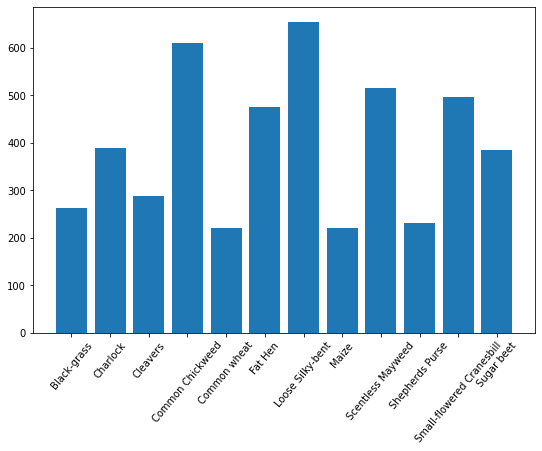

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (9,6))
ax = fig.add_subplot()
ax.bar(Classes,file_)
plt.xticks(rotation = 50)
plt.show()

#Getting data train and val

In [11]:
import tensorflow as tf
save_dir_new='/kaggle/input/plant-seedlings-classification/train'

In [12]:
def get_training_data( model):
    datagen = ImageDataGenerator(preprocessing_function =  vgg16.preprocess_input, validation_split=0.1)
    
    train_data_den = datagen.flow_from_directory(
            directory= os.path.join(save_dir_new),
            class_mode = "categorical",
            batch_size=32,
            shuffle=True,
            subset='training'
        )
        
    val_data_gen = datagen.flow_from_directory(
            directory= os.path.join(save_dir_new),
            class_mode = 'categorical',
            batch_size=32,
            shuffle=False,
            subset='validation'
        )

    return train_data_den, val_data_gen

# Confusion Matrix

In [13]:
def plot_confusion_matrix(cm, classes, normalize=False,title='Confusion matrix',cmap=plt.cm.Greens):
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

# Class Weights

In [14]:
import glob

file_num = []
for i in range(12) :
    imfile = glob.glob('/kaggle/input/plant-seedlings-classification/train/'+Classes[i]+'/*.png')
    file_num += [len(imfile)]

(file_num)

[263, 390, 287, 611, 221, 475, 654, 221, 516, 231, 496, 385]

In [15]:
import numpy as np
import math

def create_class_weight(labels_dict,mu=0.15):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0
    
    return class_weight

labels_dict = {0:263, 1:390, 2:287, 3:611, 4:221, 5:475, 6:654, 7:221, 8:516,9: 231, 10:496, 11:385}

create_class_weight(labels_dict)

{0: 1.0,
 1: 1.0,
 2: 1.0,
 3: 1.0,
 4: 1.1706172106250528,
 5: 1.0,
 6: 1.0,
 7: 1.1706172106250528,
 8: 1.0,
 9: 1.126362201621012,
 10: 1.0,
 11: 1.0}

#Plot 

In [16]:
def plots(model):
    plt.plot(np.array(model.history['accuracy']) * 100)
    plt.plot(np.array(model.history['val_accuracy']) * 100)
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.legend(['train', 'validation'])
    plt.title('Accuracy vs epochs')
    plt.show()

In [17]:
#Final score and accuracy of the model train and test
def Calculate(model_name):

    score2, acc2 = model_name.history.evaluate(val_gen)
    score1, acc1 = model_name.history.evaluate(train_gen)


    print('Validation score:', score2,'   Validation accuracy:', acc2)
    print('Train score:', score1,'   Train accuracy:',acc1)

#VGG callbacks


In [18]:
checkpoint = ModelCheckpoint(filepath=os.path.join('/kaggle/input/','vgg16','.h5'), monitor='val_loss', mode='min', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.00001)
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='min', restore_best_weights=True)
callbacksvgg=[checkpoint,reduce_lr,es]
train_gen_vgg, val_gen_vgg = get_training_data(model = 'vgg16')


Found 4279 images belonging to 12 classes.
Found 471 images belonging to 12 classes.


In [ ]:
checkpoint1 = ModelCheckpoint(filepath=os.path.join('/kaggle/input/','vgg16','.h5'), monitor='val_loss', mode='min', save_best_only=True)
reduce_lr1 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.00001)
early_stop1 = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='min', restore_best_weights=True)
callbacksvgg1=[checkpoint1,reduce_lr1,early_stop1]
train_gen_vgg1, val_gen_vgg1 = get_training_data(model = 'vgg16')


Found 4279 images belonging to 12 classes.
Found 471 images belonging to 12 classes.


In [ ]:
prior_vgg1 = VGG16(weights='imagenet', include_top=False, pooling='max', input_shape=(224, 224, 3))


58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
prior_vgg1.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# MODEL

In [22]:
prior_vgg = VGG16(weights='imagenet', include_top=False, pooling='max', input_shape=(224, 224, 3))
xv = prior_vgg.output
xv = Dropout(0.6)(xv)
xv = Dense(512)(xv)
xv = BatchNormalization()(xv)
xv = swish(xv)
xv = Dropout(0.5)(xv)
out = Dense(12, activation='softmax')(xv)
vggmodel = Model(inputs = prior_vgg.input, outputs = out)
for layer in prior_vgg.layers[0:-4]:
    layer.trainable = False
    
vggmodel.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [23]:
VGG = vggmodel.fit_generator(train_gen_vgg,
                      validation_data = val_gen_vgg,
                      epochs = 50,
                      verbose = 1,
                      class_weight=create_class_weight(labels_dict),
                      shuffle=True,
                      callbacks = callbacksvgg)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
134/134 [==============================] - 124s 612ms/step - loss: 2.2362 - accuracy: 0.2940 - val_loss: 1.1447 - val_accuracy: 0.6582
Epoch 2/50
134/134 [==============================] - 71s 529ms/step - loss: 1.2263 - accuracy: 0.6107 - val_loss: 0.6966 - val_accuracy: 0.8110
Epoch 3/50
134/134 [==============================] - 71s 527ms/step - loss: 0.8148 - accuracy: 0.7558 - val_loss: 0.5481 - val_accuracy: 0.8556
Epoch 4/50
134/134 [==============================] - 72s 537ms/step - loss: 0.5970 - accuracy: 0.8179 - val_loss: 0.4038 - val_accuracy: 0.8896
Epoch 5/50
134/134 [==============================] - 71s 526ms/step - loss: 0.4564 - accuracy: 0.8652 - val_loss: 0.3600 - val_accuracy: 0.8960
Epoch 6/50
134/134 [==============================] - 72s 538ms/step - loss: 0.3706 - accuracy: 0.8927 - val_loss: 0.3194 - val_accuracy: 0.9002
Epoch 7/50
134/134 [==============================] - 72s 532ms/step - loss: 0.2939 - accuracy: 0.9180 - val_loss: 0.2955 - val_a

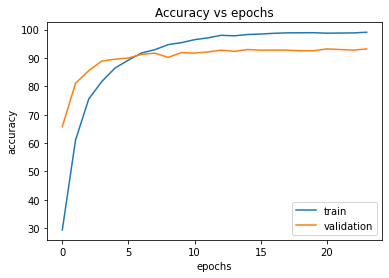

In [25]:
plots(VGG)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Classification Report
                           precision    recall  f1-score   support

              Black-grass       0.76      0.50      0.60        26
                 Charlock       1.00      1.00      1.00        39
                 Cleavers       1.00      0.93      0.96        28
         Common Chickweed       0.98      0.98      0.98        61
             Common wheat       0.83      0.86      0.84        22
                  Fat Hen       1.00      0.91      0.96        47
         Loose Silky-bent       0.81      0.98      0.89        65
                    Maize       1.00      0.95      0.98        22
        Scentless Mayweed       0.93      1.00      0.96        51
          Shepherds Purse       0.95      0.87      0.91        23
Small-flowered Cranesbill       1.00      0.96      0.98        49
               Sugar beet       0.92      0.95      0.94        38

                 accuracy                           0.93       471
                macro avg       0.93  

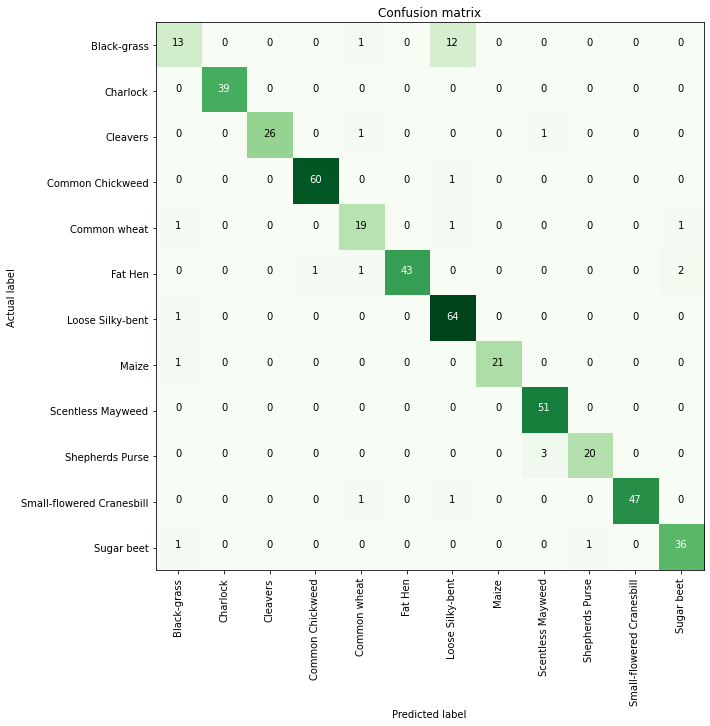

In [26]:
#val
import itertools
predictions = vggmodel.predict_generator(val_gen_vgg)
y_predval_vgg = np.argmax(predictions, axis=1)
cf_matrix = confusion_matrix(val_gen_vgg.classes, y_predval_vgg)
print('Classification Report')
print(classification_report(val_gen_vgg.classes, y_predval_vgg, target_names=Classes))
#plt.figure(figsize=(20,20))
confusionMTX = confusion_matrix(val_gen_vgg.classes, y_predval_vgg) 
# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = Classes) 
#sns.heatmap(cf_matrix, annot=True, xticklabels=Classes, yticklabels=Classes, cmap='Blues')

#Predict

In [ ]:
test_dir='/kaggle/input/plant-seedlings-classification/test'

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function =  vgg16.preprocess_input)
    
test_generator = test_datagen.flow_from_directory(
    directory='/kaggle/input/plant-seedlings-classification/',
    classes=['test'],
    target_size=(224, 224),
    batch_size=32,
    shuffle=False,
    class_mode='categorical',
    seed=1
)


Found 794 images belonging to 1 classes.


In [ ]:
predictions = vggmodel.predict(test_generator)
y_predval_vgg = np.argmax(predictions, axis=1)

In [ ]:
preds = vggmodel.predict(test_generator)

In [ ]:
y_predval=np.argmax(preds,axis=1)

In [ ]:
class_list = []
for i in range(preds.shape[0]):
    y_class = preds[i,:].argmax(axis=-1)
    class_list.append(Classes[y_class])
    


In [ ]:
class_list

['Small-flowered Cranesbill',
 'Fat Hen',
 'Sugar beet',
 'Common Chickweed',
 'Sugar beet',
 'Loose Silky-bent',
 'Common Chickweed',
 'Fat Hen',
 'Loose Silky-bent',
 'Loose Silky-bent',
 'Fat Hen',
 'Small-flowered Cranesbill',
 'Sugar beet',
 'Scentless Mayweed',
 'Sugar beet',
 'Fat Hen',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Common Chickweed',
 'Shepherds Purse',
 'Common Chickweed',
 'Small-flowered Cranesbill',
 'Shepherds Purse',
 'Sugar beet',
 'Sugar beet',
 'Maize',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Common Chickweed',
 'Sugar beet',
 'Common Chickweed',
 'Shepherds Purse',
 'Loose Silky-bent',
 'Sugar beet',
 'Loose Silky-bent',
 'Loose Silky-bent',
 'Loose Silky-bent',
 'Loose Silky-bent',
 'Common Chickweed',
 'Maize',
 'Loose Silky-bent',
 'Common wheat',
 'Common Chickweed',
 'Small-flowered Cranesbill',
 'Black-grass',
 'Sugar beet',
 'Maize',
 'Scentless Mayweed',
 'Maize',
 'Small-flowered Cranesbill',
 'Loose Silky-bent',
 'Sugar beet',
 'Cleaver

In [ ]:
submission = pd.DataFrame()
submission['file'] = test_generator.filenames
submission['file'] = submission['file'].str.replace(r'test/', '')
submission['species'] = class_list
submission.to_csv('submission1.csv', index=False)

In [ ]:
submission.to_csv('submission1.csv', index=False)

#RES

In [38]:
checkpointe = ModelCheckpoint(filepath=os.path.join('/kaggle/input/','resnet50','.h5'), monitor='val_loss', mode='min', save_best_only=True)
reduce_lre = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.00001)
early_stope = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='min', restore_best_weights=True)
callbacksres=[checkpointe,reduce_lre,early_stope]
train_gen_res, val_gen_res = get_training_data(model = 'resnet50')

Found 4279 images belonging to 12 classes.
Found 471 images belonging to 12 classes.


In [41]:
prior_resnet = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
xr = prior_resnet.output
xr = Dropout(0.8)(xr)
xr = Dense(1024)(xr)
xr = BatchNormalization()(xr)
xr = swish(xr)
xr = Dropout(0.6)(xr)
lastres = Dense(12, activation='softmax')(xr)
res_model = Model(inputs = prior_resnet.input, outputs = lastres)

for layer in prior_resnet.layers[0:-9]:
    layer.trainable = False
    
res_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [42]:
res = res_model.fit_generator(train_gen_res,
                      validation_data = val_gen_res,
                      epochs = 50,
                      verbose = 1,
                      class_weight=create_class_weight(labels_dict),
                      callbacks = callbacksres)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
134/134 [==============================] - 79s 558ms/step - loss: 1.2555 - accuracy: 0.6149 - val_loss: 0.5305 - val_accuracy: 0.8174
Epoch 2/50
134/134 [==============================] - 72s 536ms/step - loss: 0.4863 - accuracy: 0.8343 - val_loss: 0.4955 - val_accuracy: 0.8747
Epoch 3/50
134/134 [==============================] - 72s 534ms/step - loss: 0.3119 - accuracy: 0.8920 - val_loss: 0.3308 - val_accuracy: 0.8960
Epoch 4/50
134/134 [==============================] - 72s 535ms/step - loss: 0.2536 - accuracy: 0.9131 - val_loss: 0.4057 - val_accuracy: 0.8747
Epoch 5/50
134/134 [==============================] - 71s 530ms/step - loss: 0.1721 - accuracy: 0.9409 - val_loss: 0.2664 - val_accuracy: 0.9172
Epoch 6/50
134/134 [==============================] - 72s 538ms/step - loss: 0.1201 - accuracy: 0.9577 - val_loss: 0.2547 - val_accuracy: 0.9257
Epoch 7/50
134/134 [==============================] - 73s 540ms/step - loss: 0.0932 - accuracy: 0.9694 - val_loss: 0.2763 - val_ac

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Classification Report
                           precision    recall  f1-score   support

              Black-grass       0.75      0.81      0.78        26
                 Charlock       1.00      0.97      0.99        39
                 Cleavers       1.00      0.93      0.96        28
         Common Chickweed       0.95      0.98      0.97        61
             Common wheat       0.94      0.77      0.85        22
                  Fat Hen       0.96      0.98      0.97        47
         Loose Silky-bent       0.86      0.92      0.89        65
                    Maize       1.00      0.91      0.95        22
        Scentless Mayweed       0.88      0.98      0.93        51
          Shepherds Purse       1.00      0.83      0.90        23
Small-flowered Cranesbill       0.98      0.96      0.97        49
               Sugar beet       1.00      0.95      0.97        38

                 accuracy                           0.93       471
                macro avg       0.94  

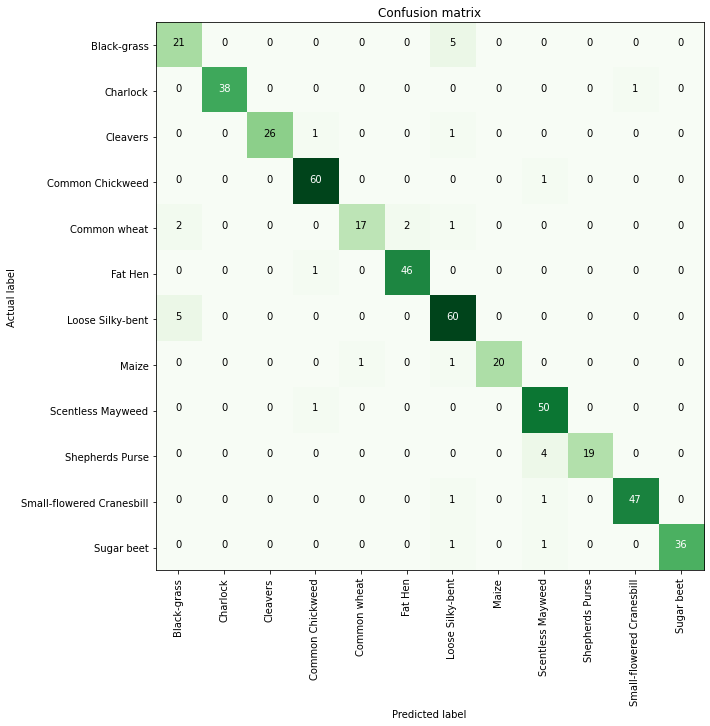

In [43]:
#val
import itertools
predictions = res_model.predict_generator(val_gen_vgg)
y_predval_vgg = np.argmax(predictions, axis=1)
cf_matrix = confusion_matrix(val_gen_vgg.classes, y_predval_vgg)
print('Classification Report')
print(classification_report(val_gen_vgg.classes, y_predval_vgg, target_names=Classes))
#plt.figure(figsize=(20,20))
confusionMTX = confusion_matrix(val_gen_vgg.classes, y_predval_vgg) 
# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = Classes) 
#sns.heatmap(cf_matrix, annot=True, xticklabels=Classes, yticklabels=Classes, cmap='Blues')

#Predict

In [ ]:
test_dir='/kaggle/input/plant-seedlings-classification/test'


In [53]:
test_datagen = ImageDataGenerator(preprocessing_function =  vgg16.preprocess_input)
    
test_generator = test_datagen.flow_from_directory(
    directory='/kaggle/input/plant-seedlings-classification/',
    classes=['test'],
    target_size=(224, 224),
    batch_size=32,
    shuffle=False,
    class_mode='categorical',
    seed=1
)


Found 794 images belonging to 1 classes.


In [54]:
predictions = res_model.predict(test_generator)
y_predval_vgg = np.argmax(predictions, axis=1)

In [55]:
preds = vggmodel.predict(test_generator)

In [56]:
y_predval=np.argmax(preds,axis=1)

In [57]:
class_list = []
for i in range(preds.shape[0]):
    y_class = preds[i,:].argmax(axis=-1)
    class_list.append(Classes[y_class])
    


In [58]:
class_list

['Small-flowered Cranesbill',
 'Fat Hen',
 'Sugar beet',
 'Common Chickweed',
 'Sugar beet',
 'Loose Silky-bent',
 'Common Chickweed',
 'Fat Hen',
 'Loose Silky-bent',
 'Loose Silky-bent',
 'Fat Hen',
 'Small-flowered Cranesbill',
 'Sugar beet',
 'Scentless Mayweed',
 'Sugar beet',
 'Fat Hen',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Common Chickweed',
 'Shepherds Purse',
 'Common Chickweed',
 'Small-flowered Cranesbill',
 'Shepherds Purse',
 'Sugar beet',
 'Sugar beet',
 'Maize',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Common Chickweed',
 'Sugar beet',
 'Common Chickweed',
 'Shepherds Purse',
 'Loose Silky-bent',
 'Sugar beet',
 'Loose Silky-bent',
 'Loose Silky-bent',
 'Loose Silky-bent',
 'Loose Silky-bent',
 'Common Chickweed',
 'Maize',
 'Loose Silky-bent',
 'Common wheat',
 'Common Chickweed',
 'Small-flowered Cranesbill',
 'Black-grass',
 'Sugar beet',
 'Maize',
 'Scentless Mayweed',
 'Maize',
 'Small-flowered Cranesbill',
 'Loose Silky-bent',
 'Sugar beet',
 'Cleaver

In [59]:
submission = pd.DataFrame()
submission['file'] = test_generator.filenames
submission['file'] = submission['file'].str.replace(r'test/', '')
submission['species'] = class_list
submission.to_csv('submission1.csv', index=False)